# Task 2: Community Detection & Proximity Analysis

## MetaFam Knowledge Graph Analysis

This notebook implements Task 2 of the MetaFam analysis:

1. **Community Detection**: Girvan-Newman, Louvain, and Leiden algorithms
2. **Evaluation Metrics**: Modularity, NMI, and ARI comparisons
3. **Generational Analysis**: Depth distribution per community
4. **Proximity Measures**: RWR and Katz Index for finding closest relatives
5. **Final Export**: Graph with community attributes to Gephi

---

## 1. Setup & Data Loading

In [1]:
# Standard imports
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add src to path
from pathlib import Path
src_path = Path('../src').resolve()
sys.path.insert(0, str(src_path))

# Scientific computing
import numpy as np
import pandas as pd
import networkx as nx

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Custom modules
from data_loader import load_graph, get_relationship_counts
from exploration import (
    calculate_global_metrics, calculate_node_features,
    infer_gender, export_to_gephi
)
from communities import (
    girvan_newman_communities, louvain_communities, leiden_communities,
    calculate_modularity, calculate_nmi, calculate_ari,
    analyze_generational_depth_per_community, plot_generational_histogram,
    assign_community_attribute, run_all_community_detection
)
from proximity import (
    find_closest_relatives, analyze_proximity_for_node_types,
    compare_proximity_methods
)

print("All modules loaded successfully.")

All modules loaded successfully.


In [2]:
# Load the graph
DATA_PATH = Path('../data/raw/train.txt')
G_directed, G_undirected = load_graph(DATA_PATH)

print(f"Loaded graph: {G_directed.number_of_nodes()} nodes, {G_directed.number_of_edges()} edges")

Loading graph from: ..\data\raw\train.txt
--------------------------------------------------

GRAPH CONSTRUCTION SANITY CHECK

DATA STATISTICS:
   - Total triples processed: 13,821
   - Unique relationship types: 28

DIRECTED GRAPH (G_directed):
   - Nodes: 1,316
   - Edges: 13,821
   - Graph type: DiGraph

UNDIRECTED GRAPH (G_undirected):
   - Nodes: 1,316
   - Edges: 7,480
   - Graph type: Graph
Loaded graph: 1316 nodes, 13821 edges


In [3]:
# Calculate node features (from Task 1)
G_directed = calculate_node_features(G_directed, verbose=True)
G_directed, gender_summary = infer_gender(G_directed, verbose=True)


CALCULATING NODE FEATURES

Computing degree metrics...
   - In-Degree:    min=0, max=23, mean=10.50
   - Out-Degree:   min=1, max=22, mean=10.50

Computing centrality metrics...


   - PageRank: max=0.001857, mean=0.000760
   - Betweenness: max=0.0001, mean=0.0000 (analysis only)

   Top 5 nodes by PageRank (Important Ancestors):
      - gabriel241: 0.001857
      - lea1165: 0.001841
      - raphael29: 0.001809
      - christian712: 0.001682
      - tobias713: 0.001682

   Top 5 nodes by Betweenness (Family Bridges):
      - lea1165: 0.0001
      - valentin638: 0.0001
      - gabriel241: 0.0001
      - nora536: 0.0001
      - stefan1192: 0.0001

Computing generational depth...
   - Parental subgraph: 4326 parent->descendant edges
   - Generation range: 0 to 3
   - Mean generation: 0.78

   Generation Distribution:
      Gen 0: 519 people
      Gen 1: 572 people
      Gen 2: 216 people
      Gen 3: 9 people

Node features successfully added to graph.

GENDER INFERENCE

GENDER CLASSIFICATION SUMMARY:
   - Male:     646 nodes
   - Female:   670 nodes
   - Unknown:  0 nodes
   - Unmapped: 0 nodes (conflicts)



---

## 2. Community Detection Algorithms

We apply three community detection algorithms:

| Algorithm | Method | Complexity | Best For |
|-----------|--------|------------|----------|
| **Girvan-Newman** | Edge betweenness removal | O(m²n) | Small graphs, interpretable hierarchy |
| **Louvain** | Modularity optimization | O(n log n) | Large graphs, fast results |
| **Leiden** | Improved Louvain | O(n log n) | Guaranteed connectivity |

### 2.1 Girvan-Newman Algorithm

In [4]:
# Girvan-Newman community detection
gn_partition, gn_communities = girvan_newman_communities(G_undirected, verbose=True)


GIRVAN-NEWMAN COMMUNITY DETECTION
Finding optimal partition via modularity...
   Iteration 10: 60 communities, Q=0.9780
   Iteration 20: 70 communities, Q=0.9767
   Iteration 30: 80 communities, Q=0.9754
   Iteration 40: 90 communities, Q=0.9741
   Iteration 50: 100 communities, Q=0.9728
   Iteration 60: 110 communities, Q=0.9715
   Iteration 70: 120 communities, Q=0.9702
   Iteration 80: 130 communities, Q=0.9681
   Iteration 90: 140 communities, Q=0.9653
   Iteration 100: 150 communities, Q=0.9598

Results:
   - Number of communities: 51
   - Largest community: 27 nodes
   - Smallest community: 1 nodes
   - Community sizes (top 10): [27, 27, 27, 27, 27, 27, 27, 27, 27, 27]
   - Modularity: 0.9792


### 2.2 Louvain Algorithm

In [5]:
# Louvain community detection
louvain_partition, louvain_communities = louvain_communities(G_directed, resolution=1.0, verbose=True)


LOUVAIN COMMUNITY DETECTION
Note: Converted directed graph to undirected for analysis.
Resolution parameter: 1.0

Results:
   - Number of communities: 50
   - Largest community: 27 nodes
   - Smallest community: 26 nodes
   - Community sizes (top 10): [27, 27, 27, 27, 27, 27, 27, 27, 27, 27]
   - Modularity: 0.9794


### 2.3 Leiden Algorithm

In [6]:
# Leiden community detection
leiden_partition, leiden_communities_list = leiden_communities(G_directed, resolution=1.0, verbose=True)


LEIDEN COMMUNITY DETECTION
Note: Converted directed graph to undirected for analysis.
Resolution parameter: 1.0

Results:
   - Number of communities: 50
   - Largest community: 27 nodes
   - Smallest community: 26 nodes
   - Community sizes (top 10): [27, 27, 27, 27, 27, 27, 27, 27, 27, 27]
   - Modularity: 0.9794


---

## 3. Evaluation Metrics

### Modularity Comparison

Modularity measures the quality of community structure:
- **Q > 0.3**: Good community structure
- **Q > 0.5**: Strong community structure

In [7]:
# Calculate modularity for all three partitions
gn_mod = calculate_modularity(G_directed, gn_partition)
louvain_mod = calculate_modularity(G_directed, louvain_partition)
leiden_mod = calculate_modularity(G_directed, leiden_partition)

print("MODULARITY COMPARISON")
print("=" * 50)
print(f"{'Algorithm':<20} {'Communities':<15} {'Modularity':<15}")
print("-" * 50)
print(f"{'Girvan-Newman':<20} {len(gn_communities):<15} {gn_mod:.4f}")
print(f"{'Louvain':<20} {len(louvain_communities):<15} {louvain_mod:.4f}")
print(f"{'Leiden':<20} {len(leiden_communities_list):<15} {leiden_mod:.4f}")
print("=" * 50)

MODULARITY COMPARISON
Algorithm            Communities     Modularity     
--------------------------------------------------
Girvan-Newman        51              0.9792
Louvain              50              0.9794
Leiden               50              0.9794


### NMI and ARI Comparison

- **NMI (Normalized Mutual Information)**: 0 = independent, 1 = identical
- **ARI (Adjusted Rand Index)**: 0 = random, 1 = perfect agreement

In [8]:
# Pairwise comparison of partitions
print("\nPAIRWISE PARTITION COMPARISON (NMI / ARI)")
print("=" * 60)

# Girvan-Newman vs Louvain
nmi_gl = calculate_nmi(gn_partition, louvain_partition)
ari_gl = calculate_ari(gn_partition, louvain_partition)
print(f"Girvan-Newman vs Louvain: NMI = {nmi_gl:.4f}, ARI = {ari_gl:.4f}")

# Girvan-Newman vs Leiden
nmi_gd = calculate_nmi(gn_partition, leiden_partition)
ari_gd = calculate_ari(gn_partition, leiden_partition)
print(f"Girvan-Newman vs Leiden:  NMI = {nmi_gd:.4f}, ARI = {ari_gd:.4f}")

# Louvain vs Leiden
nmi_ld = calculate_nmi(louvain_partition, leiden_partition)
ari_ld = calculate_ari(louvain_partition, leiden_partition)
print(f"Louvain vs Leiden:        NMI = {nmi_ld:.4f}, ARI = {ari_ld:.4f}")

print("=" * 60)


PAIRWISE PARTITION COMPARISON (NMI / ARI)
Girvan-Newman vs Louvain: NMI = 0.9996, ARI = 0.9992
Girvan-Newman vs Leiden:  NMI = 0.9996, ARI = 0.9992
Louvain vs Leiden:        NMI = 1.0000, ARI = 1.0000


In [9]:
# Create summary DataFrame
metrics_df = pd.DataFrame({
    'Algorithm': ['Girvan-Newman', 'Louvain', 'Leiden'],
    'Communities': [len(gn_communities), len(louvain_communities), len(leiden_communities_list)],
    'Modularity': [gn_mod, louvain_mod, leiden_mod]
})

comparison_df = pd.DataFrame({
    'Comparison': ['GN vs Louvain', 'GN vs Leiden', 'Louvain vs Leiden'],
    'NMI': [nmi_gl, nmi_gd, nmi_ld],
    'ARI': [ari_gl, ari_gd, ari_ld]
})

print("\nSUMMARY TABLES")
print("\n--- Modularity Results ---")
display(metrics_df)

print("\n--- Partition Similarity ---")
display(comparison_df)


SUMMARY TABLES

--- Modularity Results ---


,Algorithm,Communities,Modularity
0,Girvan-Newman,51,0.979226
1,Louvain,50,0.979357
2,Leiden,50,0.979357



--- Partition Similarity ---


,Comparison,NMI,ARI
0,GN vs Louvain,0.999585,0.999204
1,GN vs Leiden,0.999585,0.999204
2,Louvain vs Leiden,1.000000,1.000000


---

## 4. Generational Depth Analysis per Community

Analyzing how generations are distributed within each community reveals whether communities represent:
- **Vertical lineages**: Multiple generations, narrow width
- **Horizontal groupings**: Single generation, wide sibling groups
- **Extended families**: Mixed structures spanning generations

In [10]:
# Use Louvain partition (typically best modularity) for analysis
# You can change to leiden_partition or gn_partition
best_partition = louvain_partition
best_communities = louvain_communities

print(f"Using Louvain partition with {len(best_communities)} communities")

Using Louvain partition with 50 communities


In [11]:
# Analyze generational depth per community
gen_analysis = analyze_generational_depth_per_community(
    G_directed, 
    best_partition, 
    verbose=True
)


GENERATIONAL DEPTH ANALYSIS PER COMMUNITY

TOP 10 COMMUNITIES BY SIZE:
Comm   Size     Gen Span   Gen Range    Mean Gen  
--------------------------------------------------
0      27       3          0-2          0.7       
5      27       4          0-3          1.0       
8      27       3          0-2          0.8       
21     27       4          0-3          0.8       
27     27       3          0-2          0.8       
30     27       3          0-2          0.9       
41     27       3          0-2          0.7       
44     27       3          0-2          0.8       
46     27       3          0-2          0.9       
48     27       3          0-2          0.8       

OVERALL GENERATIONAL SPAN:
   - Average span: 3.12 generations
   - Max span: 4 generations
   - Single-generation communities: 0
   - Multi-generation communities: 50


Plot saved to: ../outputs/plots/community_generation_histograms.png


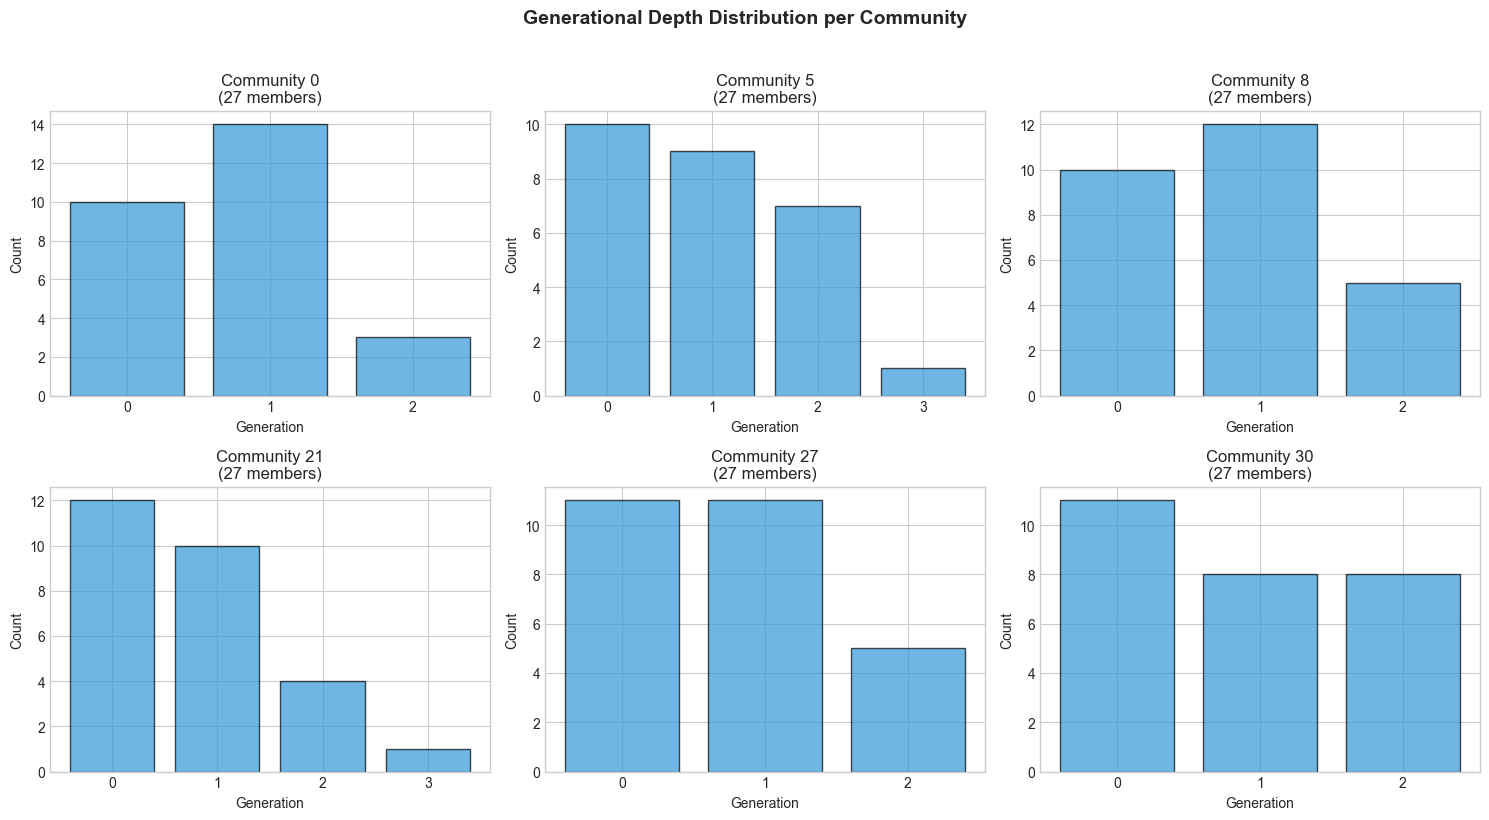

In [12]:
# Plot generational histograms for top communities
Path('../outputs/plots').mkdir(parents=True, exist_ok=True)

plot_generational_histogram(
    G_directed,
    best_partition,
    top_n_communities=6,
    save_path='../outputs/plots/community_generation_histograms.png'
)

---

## 5. Proximity Analysis: Finding Closest Relatives

### 5.1 Method Overview

| Method | Description | Best For |
|--------|-------------|----------|
| **RWR** | Random Walk with Restarts | Local structure, reachability |
| **Katz** | Path counting with attenuation | Path diversity, multiple connections |

### 5.2 Select Representative Nodes

We select 3 nodes representing different positions in the family tree:
1. **Root ancestor** (Generation 0): Oldest generation
2. **Mid-generation** (Generation 1-2): Has both ancestors and descendants
3. **Descendant** (Generation 3+): Youngest generation

In [13]:
# Get generation attributes
generations = nx.get_node_attributes(G_directed, 'generation')

# Categorize nodes
ancestors = [n for n, g in generations.items() if g == 0]
mid_gen = [n for n, g in generations.items() if g in [1, 2]]
descendants = [n for n, g in generations.items() if g >= 3]

print(f"Node distribution by generation:")
print(f"   - Generation 0 (Ancestors): {len(ancestors)} nodes")
print(f"   - Generation 1-2 (Mid): {len(mid_gen)} nodes")
print(f"   - Generation 3+ (Descendants): {len(descendants)} nodes")

Node distribution by generation:
   - Generation 0 (Ancestors): 519 nodes
   - Generation 1-2 (Mid): 788 nodes
   - Generation 3+ (Descendants): 9 nodes


In [14]:
# Select one representative from each category
import random
random.seed(42)

# Select nodes that are in communities with sufficient size
def select_node_in_large_community(node_list, partition, min_size=10):
    """Select a node from a community with at least min_size members."""
    comm_sizes = {}
    for n, c in partition.items():
        comm_sizes[c] = comm_sizes.get(c, 0) + 1
    
    valid_nodes = [n for n in node_list 
                   if n in partition and comm_sizes.get(partition[n], 0) >= min_size]
    
    if valid_nodes:
        return random.choice(valid_nodes)
    return random.choice(node_list) if node_list else None

sample_ancestor = select_node_in_large_community(ancestors, best_partition)
sample_mid = select_node_in_large_community(mid_gen, best_partition)
sample_descendant = select_node_in_large_community(descendants, best_partition)

print(f"\nSelected representative nodes:")
print(f"   - Ancestor (Gen 0): {sample_ancestor}")
print(f"   - Mid-generation: {sample_mid} (Gen {generations.get(sample_mid)})")
print(f"   - Descendant: {sample_descendant} (Gen {generations.get(sample_descendant)})")


Selected representative nodes:
   - Ancestor (Gen 0): olivia274
   - Mid-generation: dominik44 (Gen 2)
   - Descendant: adam359 (Gen 3)


### 5.3 Find Closest Relatives for Each Node Type

In [15]:
# Function to get community members
def get_community_members(partition, comm_id):
    return {n for n, c in partition.items() if c == comm_id}

# Ancestor: Find closest relatives using RWR
print("=" * 70)
print("PROXIMITY ANALYSIS: ANCESTOR NODE")
print("=" * 70)

if sample_ancestor:
    ancestor_comm = best_partition.get(sample_ancestor)
    ancestor_comm_nodes = get_community_members(best_partition, ancestor_comm)
    print(f"Node: {sample_ancestor}, Generation: 0, Community: {ancestor_comm} ({len(ancestor_comm_nodes)} members)")
    
    closest_to_ancestor = find_closest_relatives(
        G_directed, sample_ancestor,
        community_nodes=ancestor_comm_nodes,
        method='rwr',
        top_k=10,
        verbose=True
    )

PROXIMITY ANALYSIS: ANCESTOR NODE
Node: olivia274, Generation: 0, Community: 16 (26 members)

Finding closest relatives to 'olivia274' using RWR...

Top 10 closest relatives to 'olivia274':
Rank   Node                           Score          
-------------------------------------------------------
1      victoria279                    0.07292454 (Gen: 2)
2      michael288                     0.07292454 (Gen: 2)
3      gabriel273                     0.06434909 (Gen: 1)
4      matthias270                    0.06395853 (Gen: 1)
5      vanessa276                     0.06138707 (Gen: 2)
6      isabella267                    0.06138707 (Gen: 2)
7      jonas271                       0.06138707 (Gen: 2)
8      katharina266                   0.04768017 (Gen: 1)
9      sofia285                       0.03779949 (Gen: 2)
10     oliver265                      0.03645808 (Gen: 1)


In [16]:
# Mid-generation: Find closest relatives using RWR
print("\n" + "=" * 70)
print("PROXIMITY ANALYSIS: MID-GENERATION NODE")
print("=" * 70)

if sample_mid:
    mid_comm = best_partition.get(sample_mid)
    mid_comm_nodes = get_community_members(best_partition, mid_comm)
    print(f"Node: {sample_mid}, Generation: {generations.get(sample_mid)}, Community: {mid_comm} ({len(mid_comm_nodes)} members)")
    
    closest_to_mid = find_closest_relatives(
        G_directed, sample_mid,
        community_nodes=mid_comm_nodes,
        method='rwr',
        top_k=10,
        verbose=True
    )


PROXIMITY ANALYSIS: MID-GENERATION NODE
Node: dominik44, Generation: 2, Community: 1 (26 members)

Finding closest relatives to 'dominik44' using RWR...

Top 10 closest relatives to 'dominik44':
Rank   Node                           Score          
-------------------------------------------------------
1      raphael29                      0.06866919 (Gen: 2)
2      hannah39                       0.06474150 (Gen: 2)
3      marlene40                      0.05563312 (Gen: 3)
4      marie43                        0.05563312 (Gen: 1)
5      sebastian49                    0.05563312 (Gen: 1)
6      moritz31                       0.05563312 (Gen: 1)
7      marcel27                       0.05289225 (Gen: 2)
8      sofia28                        0.05000387 (Gen: 1)
9      magdalena52                    0.04793748 (Gen: 1)
10     victoria30                     0.03487085 (Gen: 0)


In [17]:
# Descendant: Find closest relatives using RWR
print("\n" + "=" * 70)
print("PROXIMITY ANALYSIS: DESCENDANT NODE")
print("=" * 70)

if sample_descendant:
    desc_comm = best_partition.get(sample_descendant)
    desc_comm_nodes = get_community_members(best_partition, desc_comm)
    print(f"Node: {sample_descendant}, Generation: {generations.get(sample_descendant)}, Community: {desc_comm} ({len(desc_comm_nodes)} members)")
    
    closest_to_desc = find_closest_relatives(
        G_directed, sample_descendant,
        community_nodes=desc_comm_nodes,
        method='rwr',
        top_k=10,
        verbose=True
    )


PROXIMITY ANALYSIS: DESCENDANT NODE
Node: adam359, Generation: 3, Community: 21 (27 members)

Finding closest relatives to 'adam359' using RWR...

Top 10 closest relatives to 'adam359':
Rank   Node                           Score          
-------------------------------------------------------
1      laura345                       0.06062313 (Gen: 2)
2      magdalena350                   0.06062313 (Gen: 2)
3      valentin351                    0.05878707 (Gen: 2)
4      konstantin347                  0.05878707 (Gen: 2)
5      selina358                      0.05484945 (Gen: 1)
6      tobias363                      0.05484945 (Gen: 1)
7      emilia365                      0.05226648 (Gen: 1)
8      leon343                        0.04810021 (Gen: 1)
9      marlene344                     0.04402295 (Gen: 1)
10     christian346                   0.03777954 (Gen: 1)


### 5.4 Compare RWR vs Katz Methods (All Node Types)

Compare both proximity methods for all three node types, showing:
- Top 10 closest relatives from each method
- Respective proximity scores
- Overlap between methods

In [18]:
# Compare RWR vs Katz for all three node types
from proximity import rwr_personalized_pagerank, katz_similarity

def compare_methods_with_scores(G, target_node, community_nodes, node_type, top_k=10):
    """Compare RWR and Katz methods showing scores for both."""
    generations = nx.get_node_attributes(G, 'generation')
    
    print(f"\n{'='*80}")
    print(f"RWR vs KATZ COMPARISON: {node_type.upper()}")
    print(f"Target Node: {target_node} (Generation: {generations.get(target_node, 'N/A')})")
    print(f"{'='*80}")
    
    # RWR scores
    rwr_scores = rwr_personalized_pagerank(G, target_node, alpha=0.85)
    rwr_filtered = {n: s for n, s in rwr_scores.items() if n in community_nodes and n != target_node}
    rwr_sorted = sorted(rwr_filtered.items(), key=lambda x: x[1], reverse=True)[:top_k]
    
    # Katz scores (raw)
    katz_scores_raw = katz_similarity(G, target_node, beta=0.1, verbose=False)
    katz_filtered_raw = {n: s for n, s in katz_scores_raw.items() if n in community_nodes and n != target_node}
    
    # Normalize Katz scores (sum normalization to make comparable to RWR probability distribution)
    katz_sum = sum(katz_filtered_raw.values())
    if katz_sum > 0:
        katz_filtered = {n: s / katz_sum for n, s in katz_filtered_raw.items()}
    else:
        katz_filtered = katz_filtered_raw
    
    katz_sorted = sorted(katz_filtered.items(), key=lambda x: x[1], reverse=True)[:top_k]
    
    # Display side by side with scores
    print(f"\n{'Rank':<5} {'RWR Node':<20} {'RWR Score':<14} {'Katz Node':<20} {'Katz Score (Norm)':<14}")
    print("-" * 80)
    
    for i in range(top_k):
        rwr_node = rwr_sorted[i][0] if i < len(rwr_sorted) else "N/A"
        rwr_score = f"{rwr_sorted[i][1]:.8f}" if i < len(rwr_sorted) else "N/A"
        katz_node = katz_sorted[i][0] if i < len(katz_sorted) else "N/A"
        katz_score = f"{katz_sorted[i][1]:.8f}" if i < len(katz_sorted) else "N/A"
        
        rwr_gen = generations.get(rwr_node, '') if rwr_node != "N/A" else ''
        katz_gen = generations.get(katz_node, '') if katz_node != "N/A" else ''
        
        rwr_display = f"{rwr_node} (G{rwr_gen})" if rwr_gen != '' else rwr_node
        katz_display = f"{katz_node} (G{katz_gen})" if katz_gen != '' else katz_node
        
        print(f"{i+1:<5} {rwr_display:<20} {rwr_score:<14} {katz_display:<20} {katz_score:<14}")
    
    # Overlap analysis
    rwr_nodes = set(n for n, _ in rwr_sorted)
    katz_nodes = set(n for n, _ in katz_sorted)
    overlap = rwr_nodes & katz_nodes
    
    print(f"\nOverlap: {len(overlap)}/{top_k} nodes ({100*len(overlap)/top_k:.0f}%)")
    if overlap:
        print(f"Common nodes: {sorted(overlap)}")
    
    return {'rwr': rwr_sorted, 'katz': katz_sorted, 'overlap': overlap}

# Compare for ANCESTOR
if sample_ancestor:
    ancestor_comparison = compare_methods_with_scores(
        G_directed, sample_ancestor, ancestor_comm_nodes, "Ancestor (Gen 0)", top_k=10
    )

# Compare for MID-GENERATION
if sample_mid:
    mid_comparison = compare_methods_with_scores(
        G_directed, sample_mid, mid_comm_nodes, f"Mid-Generation (Gen {generations.get(sample_mid)})", top_k=10
    )

# Compare for DESCENDANT
if sample_descendant:
    desc_comparison = compare_methods_with_scores(
        G_directed, sample_descendant, desc_comm_nodes, f"Descendant (Gen {generations.get(sample_descendant)})", top_k=10
    )


RWR vs KATZ COMPARISON: ANCESTOR (GEN 0)
Target Node: olivia274 (Generation: 0)



Rank  RWR Node             RWR Score      Katz Node            Katz Score (Norm)
--------------------------------------------------------------------------------
1     victoria279 (G2)     0.07292454     victoria279 (G2)     0.07354966    
2     michael288 (G2)      0.07292454     michael288 (G2)      0.07354966    
3     gabriel273 (G1)      0.06434909     matthias270 (G1)     0.06905149    
4     matthias270 (G1)     0.06395853     gabriel273 (G1)      0.06877590    
5     vanessa276 (G2)      0.06138707     vanessa276 (G2)      0.06838644    
6     isabella267 (G2)     0.06138707     isabella267 (G2)     0.06838644    
7     jonas271 (G2)        0.06138707     jonas271 (G2)        0.06838644    
8     katharina266 (G1)    0.04768017     oliver265 (G1)       0.05875914    
9     sofia285 (G2)        0.03779949     luisa268 (G1)        0.05525195    
10    oliver265 (G1)       0.03645808     amelie277 (G0)       0.05525195    

Overlap: 8/10 nodes (80%)
Common nodes: ['gabriel273', '

---

## 6. Final Export to Gephi

Export the graph with community assignments for visualization in Gephi.

In [19]:
# Add community attribute to graph
G_directed = assign_community_attribute(G_directed, best_partition, 'community')

# Verify attributes
sample_node = list(G_directed.nodes())[0]
print(f"Sample node attributes: {dict(G_directed.nodes[sample_node])}")

Sample node attributes: {'in_degree': 19, 'out_degree': 20, 'pagerank': 0.0009521976444432567, 'generation': 2, 'gender': 'Female', 'community': 0}


In [20]:
# Export to Gephi
output_path = '../outputs/gephi/metafam_final.gexf'
export_to_gephi(G_directed, output_path)


GEPHI EXPORT
All required node attributes present.

File exported: ../outputs/gephi/metafam_final.gexf
   - Nodes: 1,316
   - Edges: 13,821
   - Node attributes: ['gender', 'generation', 'in_degree', 'out_degree', 'pagerank']
   - File size: 2.68 MB

GEPHI TIPS:
   1. Import this file in Gephi (File > Open)
   2. Use 'gender' attribute for node coloring
   3. Use 'generation' for vertical layout
   4. Use 'pagerank' for node sizing (important ancestors)
   5. Run ForceAtlas2 layout for network visualization



---

## 7. Summary & Conclusions

In [21]:
print("\n" + "=" * 70)
print("TASK 2: COMMUNITY DETECTION & PROXIMITY - SUMMARY")
print("=" * 70)

print("\nCOMMUNITY DETECTION RESULTS:")
print(f"   - Girvan-Newman: {len(gn_communities)} communities (Q = {gn_mod:.4f})")
print(f"   - Louvain: {len(louvain_communities)} communities (Q = {louvain_mod:.4f})")
print(f"   - Leiden: {len(leiden_communities_list)} communities (Q = {leiden_mod:.4f})")

print("\nPARTITION SIMILARITY:")
print(f"   - Louvain vs Leiden NMI: {nmi_ld:.4f} (high = similar)")
print(f"   - Louvain vs Leiden ARI: {ari_ld:.4f}")

print("\nGENERATIONAL ANALYSIS:")
spans = [s['gen_span'] for s in gen_analysis.values() if s['gen_span'] > 0]
if spans:
    print(f"   - Average generational span per community: {np.mean(spans):.2f}")
    print(f"   - Max generational span: {max(spans)}")

print("\nOUTPUT FILES:")
print(f"   - Community histograms: outputs/plots/community_generation_histograms.png")
print(f"   - Final Gephi export: outputs/gephi/metafam_final.gexf")

print("\nNODE ATTRIBUTES IN FINAL EXPORT:")
print("   - in_degree, out_degree, pagerank, generation, gender, community")

print("\n" + "=" * 70)
print("Task 2 COMPLETE")
print("=" * 70)


TASK 2: COMMUNITY DETECTION & PROXIMITY - SUMMARY

COMMUNITY DETECTION RESULTS:
   - Girvan-Newman: 51 communities (Q = 0.9792)
   - Louvain: 50 communities (Q = 0.9794)
   - Leiden: 50 communities (Q = 0.9794)

PARTITION SIMILARITY:
   - Louvain vs Leiden NMI: 1.0000 (high = similar)
   - Louvain vs Leiden ARI: 1.0000

GENERATIONAL ANALYSIS:
   - Average generational span per community: 3.12
   - Max generational span: 4

OUTPUT FILES:
   - Community histograms: outputs/plots/community_generation_histograms.png
   - Final Gephi export: outputs/gephi/metafam_final.gexf

NODE ATTRIBUTES IN FINAL EXPORT:
   - in_degree, out_degree, pagerank, generation, gender, community

Task 2 COMPLETE


---

## Appendix: Theoretical Background

### A. Community Detection Algorithms

**Girvan-Newman**:
- Divisive hierarchical method based on edge betweenness
- Identifies "bridge" edges connecting communities
- Good for understanding hierarchical structure

**Louvain**:
- Greedy modularity optimization
- Two phases: local optimization + network aggregation
- Fast and scalable

**Leiden**:
- Improvement over Louvain
- Guarantees connected communities
- Better theoretical properties

### B. Proximity Measures

**Random Walk with Restarts (RWR)**:
- Simulates random walker that occasionally restarts at source
- Stationary distribution gives proximity scores
- Captures local structure and reachability

**Katz Index**:
- Counts all paths weighted by length: $K = \sum_{l=1}^{\infty} \beta^l A^l$
- Higher for nodes with many/short paths between them
- Good for detecting multi-path connectivity

### C. Gephi Visualization Tips

1. **Color by**: `community` attribute
2. **Size by**: `pagerank` or `out_degree`
3. **Vertical layout**: `generation` for Y-axis
4. **Layout**: ForceAtlas2 with LinLog mode